In [1]:
import time

import numpy as np
import pandas as pd
from sklearn import datasets, linear_model, model_selection, base, \
    metrics, ensemble, svm, preprocessing, neighbors
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

## Fetch Data

In [2]:
ds_name = "mnist_784"
start = time.time()
mnist = datasets.fetch_openml(ds_name, version=1)
end = time.time()
print(f"Data fetched in {round(end - start)} seconds")

Data fetched in 35 seconds


In [3]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [4]:
print(mnist["DESCR"])

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [5]:
# Quick 'n' dirty display of one of the digits
sample_ix = 5
img_shape = (28, 28)
square_sample = mnist["data"][sample_ix].reshape(img_shape)
for i in range(28):
    s = ""
    for j in range(28):
        if square_sample[i, j] == 0:
            s += ". "
        else:
            s += "O "
    print(s)

. . . . . . . . . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . O O O O O . . . . . . . . 
. . . . . . . . . . . . . O O O O O O O . . . . . . . . 
. . . . . . . . . . . O O O O O O O O O O . . . . . . . 
. . . . . . . . . O O O O O O O O O O O O . . . . . . . 
. . . . . . . . . O O O O O O O . O O O O . . . . . . . 
. . . . . . . . . O O O O O O . . O O O O . . . . . . . 
. . . . . . . . . O O O O . . . . O O O O . . . . . . . 
. . . . . . . . . . . . . . . . . O O O O . . . . . . . 
. . . . . . . . . . . . . O O O O O O O O . . . . . . . 
. . . . . . . . . . O O O O O O O O O O . . . . . . . . 
. . . . . . . . O O O O O O O O O O O O O . . . . . . . 
. . . . . . . O O O O O O . O O O O O O O O . . . . . . 
. . . . . . O O O O O O . O O O

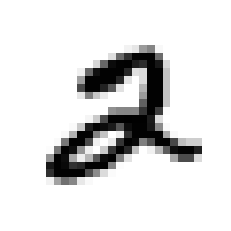

In [6]:
# With MPL instead...this is actually quicker lol
plt.imshow(square_sample, cmap="binary")
plt.axis("off");

In [7]:
X, y = mnist["data"], mnist["target"]

In [8]:
# Targets are given as strings
y[sample_ix]

'2'

## Preprocessing

In [9]:
y = y.astype(np.uint8)

In [10]:
# Construct a test set.
# Dataset is already shuffled
ix = 60000
X_train = X[:ix]
y_train = y[:ix]
X_test = X[ix:]
y_test = y[ix:]

## Binary Classifier

Simplify the problem to start -- is it possible to train a classifier to recognize the digit "5" against all other digits?

In [11]:
y_train_5 = y_train == 5
y_test_5 = y_test == 5

In [12]:
sgd_clf = linear_model.SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [13]:
sgd_clf.predict([X_train[0]])  # Known to be 5

array([ True])

In [14]:
# Evaluate the performance of the binary classifier
# 3-fold validation
scores = model_selection.cross_val_score(sgd_clf, X_train, y_train_5, cv=3)
scores

array([0.95035, 0.96035, 0.9604 ])

In [15]:
# A naive baseline to compare against
# Always predicts "not-5"

# Should have an acuracy of about 90%

class Never5Classifier(base.BaseEstimator):
    
    def fit(self, X, y=None):
        pass
    
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [16]:
nv5_clf = Never5Classifier()
scores = model_selection.cross_val_score(nv5_clf, X_train, y_train, cv=3,
                                        scoring="accuracy")
scores

array([0.0997 , 0.0965 , 0.09995])

In [17]:
start = time.time()
y_train_pred = model_selection.cross_val_predict(sgd_clf, X_train, y_train_5,
                                                cv=3)
end = time.time()
print(f"Cross validated in {round(end - start)} seconds")

Cross validated in 31 seconds


In [18]:
# Rows are actual classes
# Columsn are predicted classes
metrics.confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [19]:
# When it predicts a 5, how often is it correct?
metrics.precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [20]:
# How many of the 5's does it pick up?
metrics.recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [21]:
# F1-Score is the harmonic mean of the two
metrics.f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [22]:
# use decision_function to use custom decision boundary
y_score = sgd_clf.decision_function([X_train[0]])
y_score

array([2164.22030239])

In [23]:
thresh = 0
pred = y_score > thresh
pred

array([ True])

In [24]:
# Higher threshold results in a negative prediciton
thresh = 8000
pred = y_score > thresh
pred

array([False])

In [25]:
# Using cross_val_score
y_scores = model_selection.cross_val_predict(sgd_clf, X_train, y_train_5,
                                             method="decision_function",
                                             cv=3)

In [26]:
# Using the predicted values to crea P/R curve
prcn, rcll, threshs = metrics.precision_recall_curve(y_train_5, y_scores)

In [27]:
def plot_pr_curves(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g--", label="Recall")

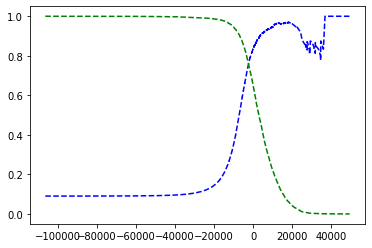

In [28]:
plot_pr_curves(prcn, rcll, threshs)

In [29]:
def plot_prec_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b")

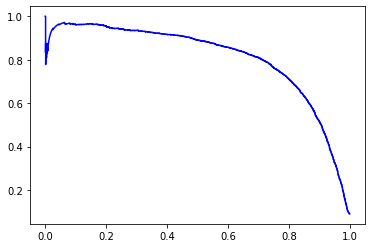

In [30]:
plot_prec_vs_recall(prcn, rcll)

In [31]:
# Create classifier by specifying a Precision threshold

precision_thresh = 0.90
ix = np.argmax(prcn >= precision_thresh)
score_thresh = threshs[ix]
y_train_pred_cust_prec = y_scores >= score_thresh

In [32]:
# As desired.
metrics.precision_score(y_train_5, y_train_pred_cust_prec)

0.9000345901072293

In [33]:
metrics.recall_score(y_train_5, y_train_pred_cust_prec)

0.4799852425751706

In [34]:
# ROC curve
fpr, tpr, threshs2 = metrics.roc_curve(y_train_5, y_scores)

In [35]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], "k--")  # Dashed diagonal for comparison
    plt.title("ROC Curve")
    plt.xlim(0, 1)
    plt.ylim(0, 1)

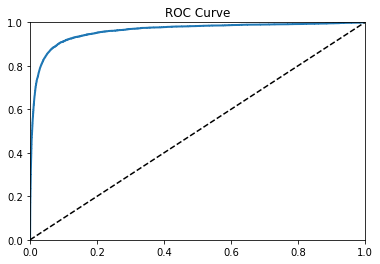

In [36]:
plot_roc_curve(fpr, tpr)

In [37]:
# AUC
metrics.roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [38]:
# Compare SGDCLassifier with a RandomForestClassifier
# Slightly different bc of .predict_proba() instead of .decision_function()
forest = ensemble.RandomForestClassifier(random_state=42)
y_probas = model_selection.cross_val_predict(forest, X_train, y_train_5,
                                            cv=3, method="predict_proba")

y_scores_forest = y_probas[:, 1]  # Score of the positive class
fpr_forest, tpr_forest, _ = metrics.roc_curve(y_train_5, y_scores_forest)

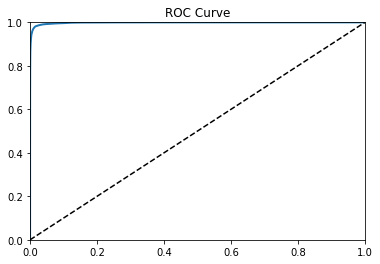

In [39]:
# The random forest is *way* better than the SGDCLassifier

plot_roc_curve(fpr_forest, tpr_forest)

In [40]:
# AUC
metrics.roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [41]:
y_preds = model_selection.cross_val_predict(forest, X_train, y_train_5,
                                           cv=3)

In [42]:
# Precision
metrics.precision_score(y_train_5, y_preds)

0.9905083315756169

In [43]:
# Recall
metrics.recall_score(y_train_5, y_preds)

0.8662608374838591

## Multiclass Classification

In [44]:
# sklearn automatically uses OvR or OvO when you use a
# binary-only classifier in a multiclass setting.
# Which one is used depends on the specific algorithm.

svm_clf = svm.SVC()
# svm_clf.fit(X_train, y_train)  # Takes a long time bc OvO is being used.
# svm_clf.predict(X_train[0])

In [47]:
# sample_scores = svm_clf.decision_function([X_train[0]])
# sample_scores

In [48]:
# With native multiclass classifier
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([X_train[0]])

array([3], dtype=uint8)

In [49]:
sgd_clf.decision_function([X_train[0]])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [50]:
model_selection.cross_val_score(sgd_clf, X_train, y_train, cv=3,
                                scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

## Error Analysis

In [54]:
scaler = preprocessing.StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [57]:
y_train_pred = model_selection.cross_val_predict(sgd_clf, X_train_scaled,
                                                y_train, cv=3)

In [63]:
conf_mx = metrics.confusion_matrix(y_train, y_train_pred)

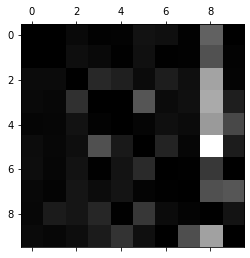

In [62]:
# Scale by class size to account for imbalance
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray);

## Multilabel Classification

In [11]:
# Create two labels to output
y_train_large = y_train >= 7
y_train_odd = y_train % 2 == 1
y_multilabel = np.c_[y_train_large, y_train_odd]

In [12]:
knn_clf = neighbors.KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [13]:
knn_clf.predict([X_train[0]])

array([[False,  True]])

In [ ]:
# y_train_knn_pred = model_selection.cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
# metrics.f1_score(y_multilabel, y_train_knn_pred, average="macro")

## Multioutput Classification

In [16]:
# Cleaning noise from an image
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_noisy = X_train + noise

noise_t = np.random.randint(0, 100, (len(X_test), 784))
X_test_noisy = X_test + noise_t

y_train_mod = X_train
y_test_mod = X_test

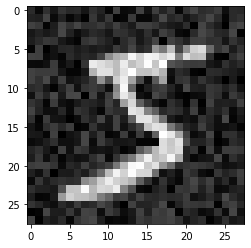

In [25]:
plt.imshow(X_train_noisy[0].reshape(28,28), cmap=plt.cm.gray);

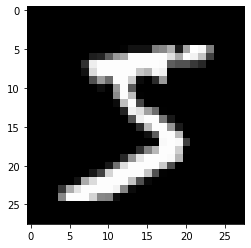

In [26]:
plt.imshow(y_train_mod[0].reshape(28,28), cmap=plt.cm.gray);

In [27]:
knn_clf.fit(X_train_noisy, y_train_mod)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

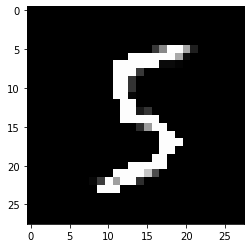

In [36]:
# Inspect a cleaned image

clean_digit = knn_clf.predict([X_train_noisy[0]])
plt.imshow(clean_digit.reshape(28,28), cmap=plt.cm.gray);